In [1]:
import h5py
import numpy as np
import os
import DSA

filepath3 = "/home/csverst/Github/InterpretabilityBenchmark/datasets/dt/20240214_NBFF_DSA_Comparison_LowerNoise_LongerTrain_3BFF_model_GRU_RNN_n_neurons_50_seed_0"
filepath4 = "/home/csverst/Github/InterpretabilityBenchmark/datasets/dt/20240214_NBFF_DSA_Comparison_LowerNoise_LongerTrain_4BFF_model_GRU_RNN_n_neurons_50_seed_0"

In [2]:
latent_list = []
hp_list = []
subdirs3 = [f.path for f in os.scandir(filepath3) ]
subdirs4 = [f.path for f in os.scandir(filepath4)]


for subdir in subdirs3:
    hp_temp0 = subdir[:-3].split("/")[-1]
    hp_temp = hp_temp0.split(" ")
    hp_temp1 = [x.split("=") for x in hp_temp]
    hp_list.append(hp_temp1)
    lat_size = hp_temp1[0][1]
    with h5py.File(subdir, "r") as f:
        latent_list.append(np.array(f["train_latents"])[:,:,0:int(lat_size)])
for subdir in subdirs4:
    hp_temp0 = subdir[:-3].split("/")[-1]
    hp_temp = hp_temp0.split(" ")
    hp_temp1 = [x.split("=") for x in hp_temp]
    hp_list.append(hp_temp1)
    lat_size = hp_temp1[0][1]
    with h5py.File(subdir, "r") as f:
        latent_list.append(np.array(f["train_latents"])[:,:,0:int(lat_size)])


8


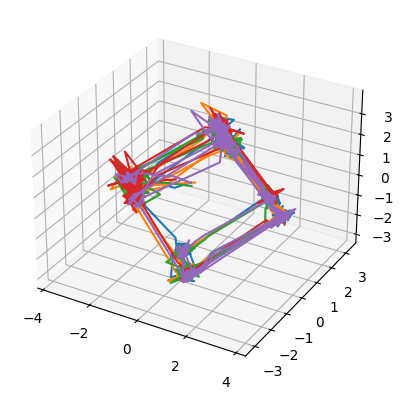

In [3]:
from matplotlib import pyplot as plt
# import PCA
from sklearn.decomposition import PCA
print(len(hp_list))
lats1 = latent_list[0]
pca = PCA(n_components=3)
pca.fit(lats1.reshape(-1, lats1.shape[-1]))
lats1_pca = pca.transform(lats1.reshape(-1, lats1.shape[-1]))
lats1_pca = lats1_pca.reshape(lats1.shape[0], lats1.shape[1], -1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(5):
    ax.plot(lats1_pca[i,:,0], lats1_pca[i,:,1], lats1_pca[i,:,2])

In [14]:

from DSA import DSA
downsample_factor = 20
n_delays = 150
rank = 200
latent_list_down = [latent[::downsample_factor] for latent in latent_list]
print(latent_list_down[0].shape)
dsa = DSA(
    latent_list_down,
    n_delays=n_delays,
    rank=rank,
    delay_interval=1,
    verbose=True,
    device='cuda',
    iters=1000,
    lr=0.005,
)
similarities = dsa.fit_score()


(40, 500, 32)
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squa

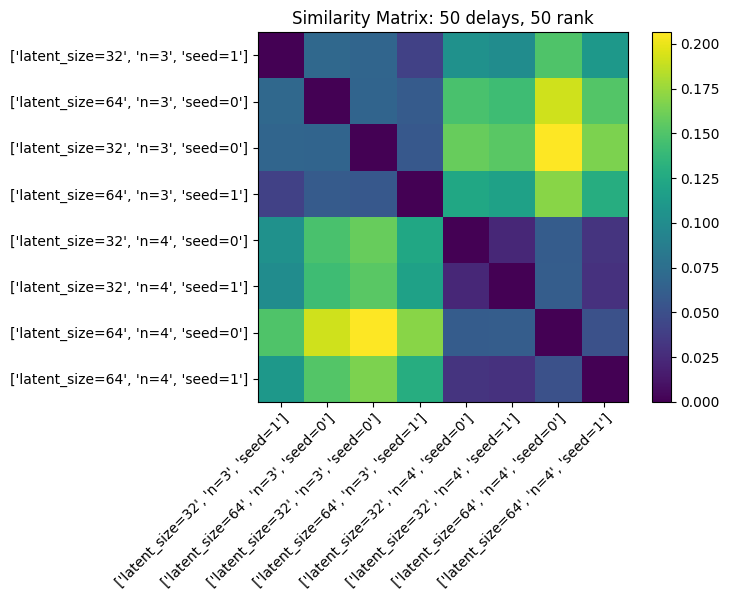

In [12]:

from matplotlib import pyplot as plt
label_list = []
fit_mat = similarities
ij_figure = plt.figure()
ij_ax = ij_figure.add_subplot(111)
# Plot it as an image
ij_ax.imshow(fit_mat)
ij_ax.set_xticks(np.arange(len(latent_list)))
ij_ax.set_yticks(np.arange(len(latent_list)))
for i in range(len(latent_list)):
    hp_temp = hp_list[i]
    label_temp = [hp[0] + "=" + hp[1] for hp in hp_temp if hp[0] not in ["max_epochs", "noise"]]
    label_list.append(label_temp)

ij_ax.set_xticklabels(label_list)
ij_ax.set_yticklabels(label_list)
# Rotate the tick labels and set their alignment.
plt.setp(
    ij_ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
)
ij_ax.set_title(f"Similarity Matrix: {n_delays} delays, {rank} rank")
# Colorbar
ij_cbar = ij_figure.colorbar(ij_ax.imshow(fit_mat), ax=ij_ax, orientation="vertical")

In [6]:
from DSA.stats import dsa_to_id, dsa_bw_data_splits, compute_all_stats
from DSA.dmd import DMD

downsample_factor = 10
latent_list_down = [latent[::downsample_factor] for latent in latent_list]
data_ind = 0

latents = latent_list_down[data_ind]
rank_sweep = [50, 100, 150, 200]
delay_sweep = [50, 100, 150, 200]
id_comp = np.zeros((len(rank_sweep), len(delay_sweep)))
splits_comp = np.zeros((len(rank_sweep), len(delay_sweep)))
recon_comp_aic = np.zeros((len(rank_sweep), len(delay_sweep)))
recon_comp_mase = np.zeros((len(rank_sweep), len(delay_sweep)))

for i, rank in enumerate(rank_sweep):
    for j, delay in enumerate(delay_sweep):
        print(f"Rank: {rank}, Delay: {delay}")
        
        dmd = DMD(latents,rank=rank,n_delays=delay,device='cuda')
        dmd.fit()
        pred = dmd.predict(latents).cpu().numpy()
        stats = compute_all_stats(pred,latents,rank=rank)
        recon_comp_aic[i, j] = stats['AIC']
        recon_comp_mase[i, j] = stats['MASE']
        id_comp[i, j] = dsa_to_id(
            data=latents,
            rank=rank,
            n_delays=delay,
            delay_interval=1,
        )
        splits_comp[i, j] = dsa_bw_data_splits(
            data=latents,
            rank=rank,
            n_delays=delay,
            delay_interval=1,
        )


Rank: 50, Delay: 50
Rank: 50, Delay: 100
Rank: 50, Delay: 150
Rank: 50, Delay: 200
Rank: 100, Delay: 50
Rank: 100, Delay: 100
Rank: 100, Delay: 150
Rank: 100, Delay: 200
Rank: 150, Delay: 50
Rank: 150, Delay: 100
Rank: 150, Delay: 150


KeyboardInterrupt: 

Text(0, 0.5, 'DSA Similarity')

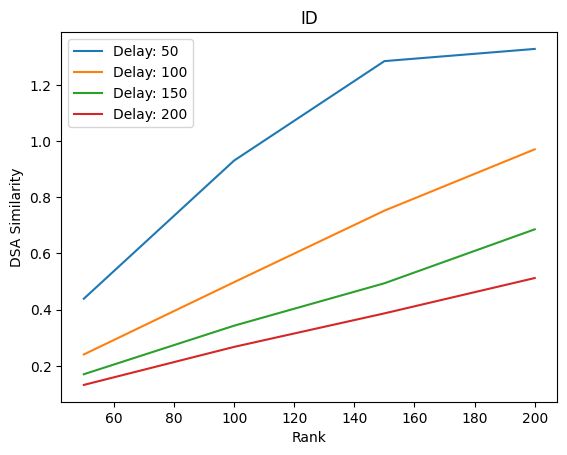

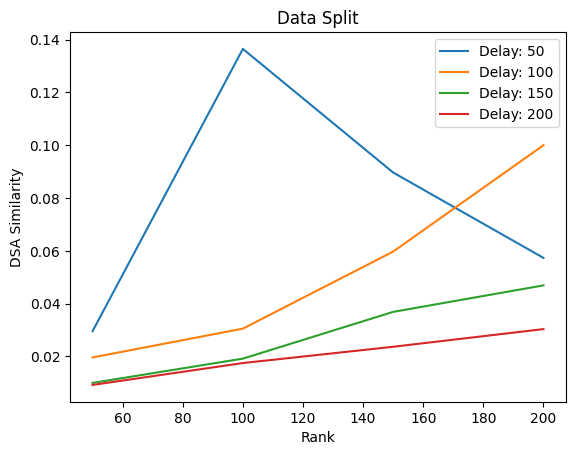

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i, rank in enumerate(delay_sweep):
    ax.plot(rank_sweep, id_comp[:, i], label=f"Delay: {rank}")
ax.set_title("ID")
ax.legend()

ax.set_xlabel("Rank")
ax.set_ylabel("DSA Similarity")


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for i, rank in enumerate(delay_sweep):
    ax2.plot(rank_sweep, splits_comp[:, i], label=f"Delay: {rank}")
ax2.set_title("Data Split")
ax2.legend()

ax2.set_xlabel("Rank")
ax2.set_ylabel("DSA Similarity")
